A recent Kaggle competition was launched that asks users to predict harvest yields from wild blueberries growing in the hills and mountains of the Northeast. As you might imagine, both the harvest and the subsequent harvest of data are not easy to come by. The dataset is actually generated from synthetic data which is itself based on a simulation of harvests that's been refined for 30 years. Background details aside, the dataset will be a good example to use for tabular modeling, where the objective is to predict one column's values based on values from the others. Tabular modeling includes decision trees and their evolved form, random forests, both of which will be focused on here using scikit-learn.

Although tabular modeling is not as attention-grabbing as NLP and image recognition, it offers many strengths in its own right for structured data:
- faster training
- ease of interpretation
- unbound by hardware constraints at scale (eg: tensor cores)
- less hyperparameter tuning
That said, there are two exceptions to this:
- high cardinality in important categorical variables
- presence of data that would be handled much better by neural networks, such as columns containing plain text

Unstructured data will always be the domain of deep learning, but for structured data the contest is less clear and it's worthwhile to consider tabular modeling--at the very least as a baseline.

## Setting up data

In [82]:
from pathlib import Path
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import dtreeviz
from IPython.display import Image, display_svg, SVG
import warnings
import seaborn as sns
# suppress the warning message from sklearn
warnings.filterwarnings(action='ignore', category=UserWarning)

data_path = Path('./data')
df = pd.read_csv(data_path/'train.csv', low_memory=False)

As described by Kaggle, this dataset is very small--barely over a megabyte--and is intended to be a lighter complement to its intenser options. Here we see just a handful of columns, many of which are related, and less than 50000 rows across both the training and test sets.

## Data prep

In [83]:
[{df[i].name:df[i].unique()[:10]} for i in df.columns]

[{'id': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)},
 {'clonesize': array([25. , 12.5, 37.5, 20. , 10. , 40. ])},
 {'honeybee': array([ 0.5  ,  0.25 ,  0.75 ,  0.537,  0.   , 18.43 ,  6.64 ])},
 {'bumbles': array([0.25 , 0.38 , 0.117, 0.058, 0.56 , 0.065, 0.   , 0.585, 0.042,
         0.293])},
 {'andrena': array([0.75 , 0.5  , 0.63 , 0.38 , 0.25 , 0.409, 0.707, 0.   , 0.24 ,
         0.56 ])},
 {'osmia': array([0.5  , 0.63 , 0.75 , 0.25 , 0.38 , 0.058, 0.117, 0.62 , 0.585,
         0.   ])},
 {'MaxOfUpperTRange': array([69.7, 86. , 77.4, 94.6, 89. , 79. ])},
 {'MinOfUpperTRange': array([42.1, 52. , 46.8, 57.2, 39. ])},
 {'AverageOfUpperTRange': array([58.2, 71.9, 64.7, 79. , 65.6])},
 {'MaxOfLowerTRange': array([50.2, 62. , 55.8, 68.2, 66. , 52. ])},
 {'MinOfLowerTRange': array([24.3, 30. , 27. , 33. , 28. , 25. , 31. ])},
 {'AverageOfLowerTRange': array([41.2, 50.8, 45.8, 55.9, 45.3])},
 {'RainingDays': array([24.  , 34.  ,  1.  , 16.  ,  3.77, 26.  ])},
 {'AverageRainingDays

Based on how few unique values they contain, the first five columns might warrant treatment as categorical variables, so we can mark them as such

In [84]:
df.clonesize = df.clonesize.astype('category')
df.honeybee = df.honeybee.astype('category')
df.bumbles = df.bumbles.astype('category')
df.andrena = df.andrena.astype('category')
df.osmia = df.osmia.astype('category')

The dependent variable we are predicting is yield, and procs are wrappers on Pandas that handle strings and missing data. This dataset does not contain strings bu the functionality are grouped together. `Categorify` is a `TabularProc` that replaces a column with a numeric categorical column. `FillMissing` is a `TabularProc` that replaces missing values with the median of the column, and creates a new Boolean column that is set to `True` for any row where the value was missing.

In [85]:
dep_var = 'yield'
procs = [Categorify, FillMissing]

Based on the structure of the dataset, we will randomly split the data into train and validation sets

In [86]:
rng = np.random.default_rng()
np.random.seed(11)
train_size = round(len(df) * .7)
train_idx = rng.integers(low=0, high=df.last_valid_index(), size=train_size)
splits = (list(train_idx), list(df.index[~train_idx]))

Tell TabularPandas which columns are continuous and categorical. Save the processed data for later use.

In [87]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)
save_pickle(data_path/'to.pkl',to)

## Creating decision trees
First define x and y, the independent and dependent variables. Then create the decision tree.

In [88]:
to = load_pickle(data_path/'to.pkl')
trn_xs,trn_y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(trn_xs, trn_y);

### Visualization
This function visualizes the decision tree for the training x data that's been passed to the tabularpandas. The first node is before anything has been done. The value is the mean of the variable we're trying to predict, yield, and the sample is the length of the dataframe.

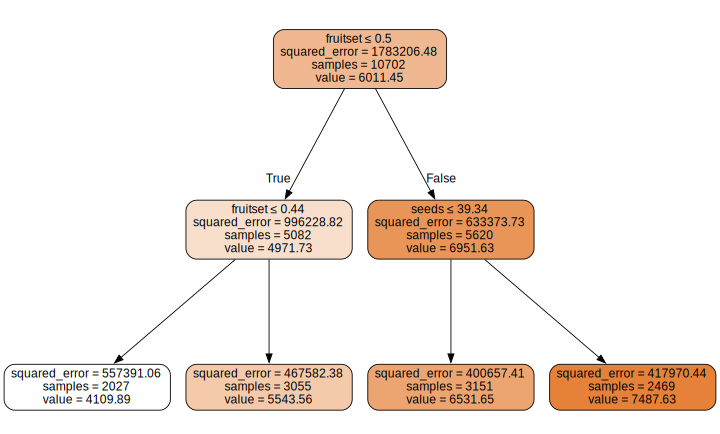

In [89]:
import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))
draw_tree(m, trn_xs, size=10)

The next two nodes come from bisecting the dataset by values for fruitset above and below 0.5.

Alternative visualization using dtreeviz, showing the distribution of data along with the bisecting lines

In [90]:
dtreeviz.model(m, X_train=trn_xs, y_train=trn_y, feature_names=df.columns, target_name=dep_var).view()

These previews were limited to just 4 nodes but now we will remove it

In [91]:
m = DecisionTreeRegressor()
m.fit(trn_xs, trn_y);

## Performance evaluation
The Kaggle competition that this data was taken from will evaluate submissions based on mean absolute error

{{< katex >}}
`$$ MAE = \frac{1}{n}\sum\limits_{i=1}^n{|x_i - y_i|} $$`{=markdown}

where each `\\( x_i \\)`{=markdown} represents the predicted target, `\\( y_i \\)`{=markdown}  represents the ground truth, and `\\( n \\)`{=markdown} is the number of rows in the test set.

In [92]:
def mae(predictions, actuals):
    """calculate the mean absolute error between prediction and actual values

    Args:
        predictions (Series): from training set
        actuals (Series): from validation set

    Returns:
        _type_: float
    """
    return abs(predictions - actuals).sum() / len(predictions)

Generating our predictions from the model and taking the MAE:

In [93]:
predictions = m.predict(trn_xs)
mae(predictions, trn_y)

0.0

Checking it against our validation set:

In [94]:
mae(m.predict(valid_xs), valid_y)

257.25559535317944

A mean absolute error of 0 indicates overfitting, as the default setting for sklearn is to continue splitting nodes until they run out. The total nodes, or leaves, in the tree is almost as high as the total rows in the training set:

In [95]:
m.get_n_leaves(), len(trn_xs)

(7433, 10702)

Changing it to 25 modes will fix the problem, bringing the MAE closer to the validation set.

In [96]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(trn_xs, trn_y)
mae(m.predict(trn_xs), trn_y)

335.8960513328999

## Trees become forest
Decision trees offer a balance of generalization and accuracy, but they are on opposite ends of a fulcrum. Limiting the size of the tree means it generalizes well at the expense of accuracy and vice versa. To overcome this compromise, data scientists started using a new technique called random forests, extending the analogy. The intuition behind random forests echoes the central limit theorem: an aggregated measure derived from several samples is more accurate than any of the individual samples. However, random forests has specific criteria
- subset and bootstrap data from the training set
- randomly use different subsets of columns when choosing splits in each decision tree

### Creating a random forest
The setup will be similar to the decision trees from earlier, specifying some of the same limits

In [97]:
def rf(xs, y, n_estimators=40, max_samples=2000, max_features=0.5, min_samples_leaf=5, **kwargs):
    """generate a random forest

    Args:
        xs (DataFrame): independent variables
        y (Series): dependent variable
        n_estimators (int, optional): number of trees. Defaults to 40.
        max_samples (_type_, optional): rows to sample for training each tree. Defaults to 2000.
        max_features (float, optional): number of features to consider when looking for the best split. Defaults to 0.5, meaning half.
        min_samples_leaf (int, optional): minimum number of samples in each leaf. Defaults to 5.

    Returns:
        _type_: _description_
    """
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

Comparing the training results to the validation set, MAE using random forest gains a slight improvement over the single large decision tree

In [98]:
m = rf(trn_xs, trn_y)
mae(m.predict(trn_xs), trn_y), mae(m.predict(valid_xs), valid_y)

(322.05531067481564, 340.15606437992363)

## Further inspection of random forest performance
The random forest we created created has 40 trees, each of which was can be accessed by indexing from `m.estimators_`, which returns a list of all the predicted yields

In [99]:
m.estimators_[3].predict(valid_xs)

array([7146.14534505, 7223.40340169, 5407.75585938, ..., 7351.00406901,
       3975.95340402, 7683.61821832])

Numpy's `stack` method allows for easy manipulations of arrays, quickly moving values from one to another as seen its documentation examples:
```python
>>> arrays = [np.random.randn(3, 4) for _ in range(10)]
>>> np.stack(arrays, axis=0).shape
(10, 3, 4)
>>> np.stack(arrays, axis=1).shape
(3, 10, 4)
>>> np.stack(arrays, axis=2).shape
(3, 4, 10)
>>> a = np.array([1, 2, 3])
>>> b = np.array([4, 5, 6])
>>> np.stack((a, b))
array([[1, 2, 3],
       [4, 5, 6]])
>>> np.stack((a, b), axis=-1)
array([[1, 4],
       [2, 5],
       [3, 6]])
```
The resulting output from `stack` is another numpy array, giving us access to the `mean` method. Usually taking the mean of an array reduces the dimensions and returns just a scalar. However, passing an optional argument will instead take the mean along either axis.

In [100]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])
len(trn_xs) == len(preds.mean(0))

True

Using this gives back the predicted yields for each decision tree (axis 1) or the entire dataset (axis 0), which will return the same MAE from as earlier

In [101]:
mae(preds.mean(0), valid_y)

340.15606437992363

This can then be used to plot how the MAE exponentially improves as more decision trees get added, starting from 0 all the way to 40, the maximun number that we specified.

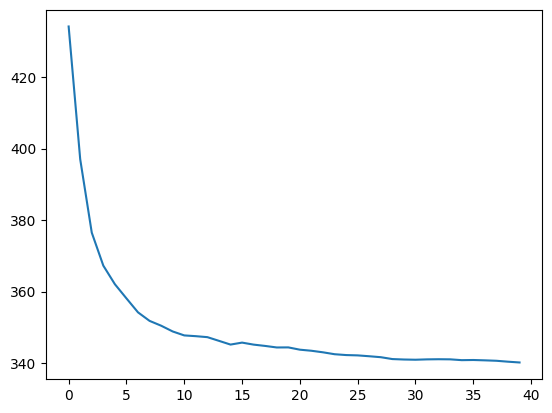

In [102]:
plt.plot([mae(preds[:i+1].mean(0), valid_y) for i in range(40)])

The model also offers `oob_prediction_`, which is like a miniature validation set. Because each tree in a random forest trains on a different subset of data, all data outside each subset is available to use in checking how well it generalizes. 

In [103]:
mae(m.oob_prediction_, trn_y)

348.34542599550673

## Model interpretation
Using the same stack from above lets us look at the random forest in greater detail. As a reminder, it has as many rows as there are trees in the model, and each row contains the subset of data available to each tree

In [104]:
preds.shape

(40, 10702)

To start off, since each decision tree is independent of the others, how do their predictions vary?

### Standard deviation
We can calculate the standard deviation for each tree along axis 0, as with the mean earlier

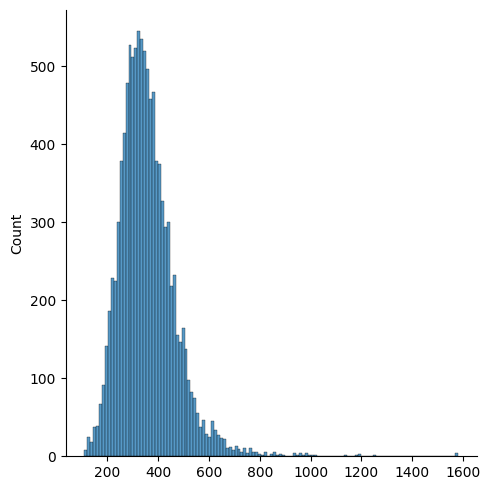

In [105]:
preds_std = preds.std(0)
sns.displot(preds_std)

The distribution is reasonably narrow for most of the data but a long right tail goes as high as 3-4 times the median.

### Immportance of features
Next, we can take advantage of the `feature_importances_` attribute from sklearn. (*Side note: there is considerable looseness of usage regarding machine learning jargon such that the library includes its own [glossary](https://scikit-learn.org/stable/glossary.html#term-feature) amongst [other glossaries](https://ml-cheatsheet.readthedocs.io/en/latest/glossary.html) created by others.*) 
It provides the importance that the model assigns to each feature of the dataset.

<AxesSubplot: xlabel='imp', ylabel='cols'>

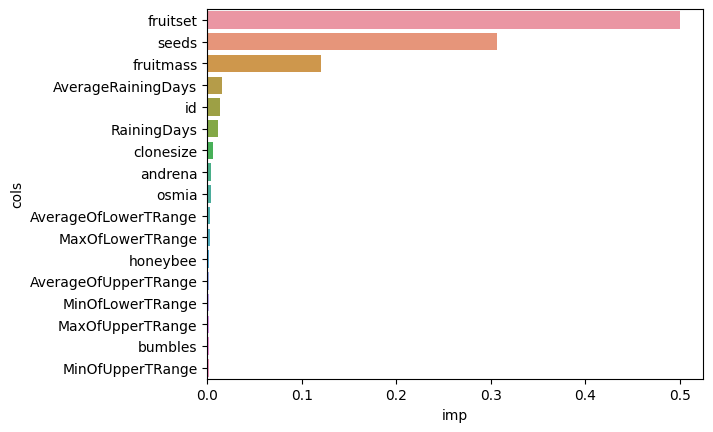

In [106]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)
fi = rf_feat_importance(m, trn_xs)
sns.barplot(fi, x='imp', y='cols', orient='h')

The model seems to think that only 3 things are important for prediction yield, and by a large margin

### Low importance variables
Considering the huge disparity in importance, we should try retraining the model with just a subset, perhaps the top three.

In [107]:
top3 = fi.nlargest(3, 'imp').cols

In [108]:
trn_xs_imp = trn_xs[top3]
valid_xs_imp = valid_xs[top3]
m = rf(trn_xs_imp, trn_y)
mae(m.predict(trn_xs_imp), trn_y)

336.87210027595984

MAE is slightly worse, but in a dataset with significantly more columns, we would have good reason to narrow our analysis of factors using the quantified importance as cutoff criteria. Here we will decide to keep the extra columns in exchange for the better score.

## Final predictions
To submit to Kaggle, all we need to do is load the test data and feed it to our random forest model, making sure the order and number of columns is consistent between both datasets. To do that, we need to repeat the relevant data processing steps and redefine the model.

In [109]:
m = rf(trn_xs, trn_y)
df_test = pd.read_csv(data_path/'test.csv', low_memory=False)
test_to = TabularPandas(df_test, procs, cat, cont)

final_preds = m.predict(test_to[trn_xs.columns])
submission = pd.DataFrame()
submission['yield'] = final_preds
submission.index += 15289
submission.to_csv("submission.csv", index=True, header=True, index_label="id")

## Limitations of tabular modeling
Due to the fundamental design of random forests, they are bad at extrapolating. Because a random forest averages the predictions of its trees, each of which average the the values in their leaves, predictions will never go beyond the range of values in the training data. The good news is that the problem can be mitigated by checking whether our model's predictive power hinges on conditions that aren't shared between the training and validation sets.

To achieve this we'll simply create a new dependent variable that marks whether data is from the training set or the validation set and use a random forest to predict it.

In [110]:
combo = pd.concat([trn_xs, valid_xs])
is_valid = np.array([0]*len(trn_xs) + [1]*len(valid_xs))

m = rf(combo, is_valid)
rf_feat_importance(m, combo)[:5]

cols       imp
5          id  0.218679
15  fruitmass  0.178972
16      seeds  0.176150
14   fruitset  0.170251
3     andrena  0.049227

We then look at the feature importance of the new model. For each feature, the higher the importance, the greater the disparity between validation and training datasets. In this case, there's not much of a discrepancy betweeen validation and training data, with the highest importance at 0.2. This result reflects the random splitting of the original data, but if it were structured differently, such as a time series, then random splitting would not have been the ideal choice, leading to greater chance of bigger discrepancies.

## Deep learning version
Now let's see what kind of MAE a neural network would produce. We need to take the same steps for data prep as with the tabular models

In [111]:
df_nn = pd.read_csv(data_path/'train.csv', low_memory=False)
df_nn.clonesize = df_nn.clonesize.astype('category')
df_nn.honeybee = df_nn.honeybee.astype('category')
df_nn.bumbles = df_nn.bumbles.astype('category')
df_nn.andrena = df_nn.andrena.astype('category')
df_nn.osmia = df_nn.osmia.astype('category')
cont_nn,cat_nn = cont_cat_split(df_nn, dep_var=dep_var)

Decision trees and random forests don't care about normalized data but neural networks definitely do. Additionally, we set the batch size pretty high to 1024 because memory consumption won't be very high with tabular data.

In [158]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)
dls = to_nn.dataloaders(1024)

In [159]:
y = to_nn.train.y
y.min(),y.max()

(1945.5306, 8969.401)

We also set the y range close to the minimum and maximum observed values for y to initialize the `tabular_learner` with and find the best learning rate

SuggestedLRs(valley=0.0014454397605732083)

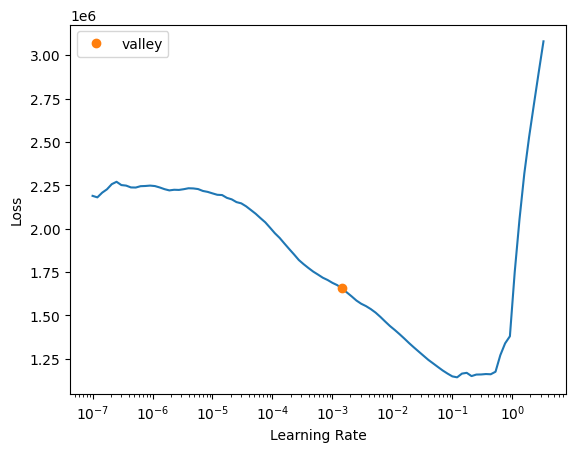

In [160]:
y = to_nn.train.y
y.min(),y.max()
learn = tabular_learner(dls, y_range=(1900, 9000), n_out=1, loss_func=F.mse_loss)
learn.lr_find()

Using a learning rate of ___, we get these training results

In [161]:
learn.fit_one_cycle(5, 1e-2)

And now we can calculate the MAE

In [162]:
preds, targets = learn.get_preds()
mae(preds, targets)

tensor(378.8834)

It's actually worse than the random forest, probably due to the tiny size of this dataset. Neural networks typically require large amounts of data to generalize well and learn complex patterns. That being said, since we expect the predictions from both models to be uncorrelated, it's worth checking to see if an ensemble of both would generate a better prediction than either. Even though the random forest is already an ensemble of decision trees, it can still feed in to yet another.

To do so, we need to format the predictions returned by the neural network, removing the tensor unit axis, and converting to numpy array

In [163]:
m = rf(trn_xs, trn_y)
nn_preds = to_np(preds.squeeze())
ens_preds = (nn_preds+ m.predict(trn_xs))/2
mae(ens_preds, valid_y)

838.4369882756597

In [164]:
nn_preds

array([6299.3184, 7205.72  , 5297.6895, ..., 7616.946 , 4395.738 ,
       7479.5327], dtype=float32)

In [165]:
m.predict(trn_xs)

array([5874.0453458 , 6095.27712292, 4406.04634156, ..., 3683.33765385,
       5841.55748665, 3292.89668876])